# Поиск похожих товаров
### Описание проекта
##### Matching 
- это задача поиска и сопоставления двух объектов из разных наборов данных. Такая потребность возникла у маркетплейса, который имеет большой перечен товаров для продажи.

Задача сопоставить и связать новые товары со старыми, пользуясь совпадающими характеристиками.

В рамках данной задачи был предоставлено 3 дата-сета:

base.cvv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv, validation_answer.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv и правильные ответы к предыдущему файлу.

В качестве метрики была задана заказчиком accuracy@5
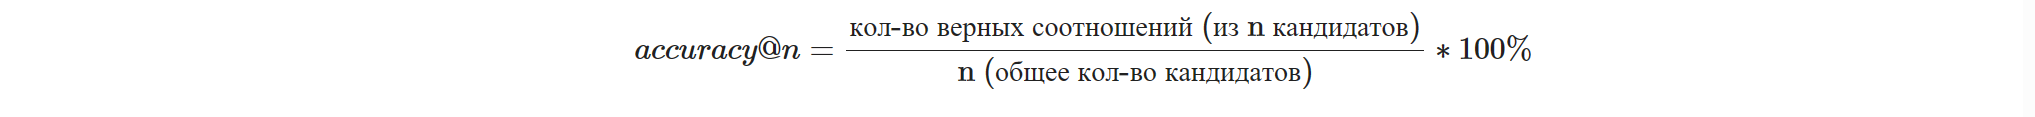     

Для решения задачи было принято решение использовать алгоритмом приближённого поиска ближайших соседей c помощью библиотеки FAISS, разработанной командой Facebook.

План работы:

- Загрузка данных
- Изучение документации библиотеки FAISS
- Подготовка данных
- Обучение базовой модели
- Подбор гипперпараметров
- Проверка финальной модели на валидационной выборке
- 

#### Подготовка

In [75]:
# Импорт нужных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import faiss
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
import time
from scipy.stats import kstest
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
#warnings.simplefilter("ignore", UserWarning)

In [2]:
np.random.seed(12345) # фиксируем генерацию случайной последовательности, чтобы не терять лучший результат

In [3]:
df_base = pd.read_csv('C:/Users/alvkh/Downloads/data/base.csv',  index_col=0)

In [62]:
df_train = pd.read_csv('C:/Users/alvkh/Downloads/data/train.csv', index_col=0)
validation = pd.read_csv('C:/Users/alvkh/Downloads/data/validation.csv', index_col=0)
validation_answer = pd.read_csv('C:/Users/alvkh/Downloads/data/validation_answer.csv', index_col=0)

In [63]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936680,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.802570,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.260390,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.697710,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.401980,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.146200,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.416750,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052540,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.092070,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995-query,-68.180530,11.657515,-63.179720,-188.726530,131.113100,-65.125340,-514.276885,95.990750,118.761185,-5.635696,...,38.573555,-133.087130,14.040794,66.477340,-36.148730,61.689774,107.037950,-1074.464888,-35.128250,811868-base
99996-query,-66.540890,2.201112,-70.292114,-146.167850,77.817140,-47.525654,-118.994688,-25.183374,131.499820,183.260880,...,33.324960,-110.576416,-84.448525,65.818100,-30.268772,133.784000,154.495860,-1144.590904,-108.663510,1460772-base
99997-query,-53.948240,4.726887,-29.278950,-147.182830,264.090670,-101.135630,-427.544045,68.057560,118.084310,192.449250,...,-14.146965,-184.663830,22.971385,67.347800,110.437100,35.785603,111.616710,-714.897734,-4.270569,2366140-base


In [64]:
validation

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926790,110.745940,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.513020,52.830902,-143.43945,59.051935,69.28224,61.927513,111.592530,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.417620,114.449910,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.441830,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.077160,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.160930,96.446160,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.795410,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.636410,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.060440,83.697080,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.236110,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.183960,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.884950,165.453920,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.770250,45.635944,-134.25893,13.735359,70.61763,15.332115,154.568120,101.700640,-1171.892332,-125.307890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995-query,-46.672780,6.644193,7.376480,-116.126400,80.031715,-48.248695,-17.696937,108.150240,122.729744,103.643906,...,-65.641110,62.823895,-148.86781,-66.402868,66.99333,76.524155,66.525670,112.273720,-177.375834,-82.804726
199996-query,-94.786316,10.852646,13.700245,-125.619385,21.545967,-89.625534,79.880236,-46.513206,123.578730,74.033020,...,-65.032900,38.019740,-113.62750,-18.436499,64.16223,-117.032380,94.026490,86.279526,-1271.502930,-63.491104
199997-query,-59.224453,13.585838,22.655106,-134.926030,145.205690,-63.278100,-109.805058,16.277431,128.150040,168.835420,...,-48.826626,39.679783,-149.33646,160.609919,71.55922,25.237282,-35.985450,97.924790,73.080770,-28.081186


In [6]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [7]:
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [8]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


Так как данные занимают много места, в дальнейшем будем сокращать до float16.

In [9]:
df_base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


In [10]:
df_base.duplicated().sum()

0

### EDA

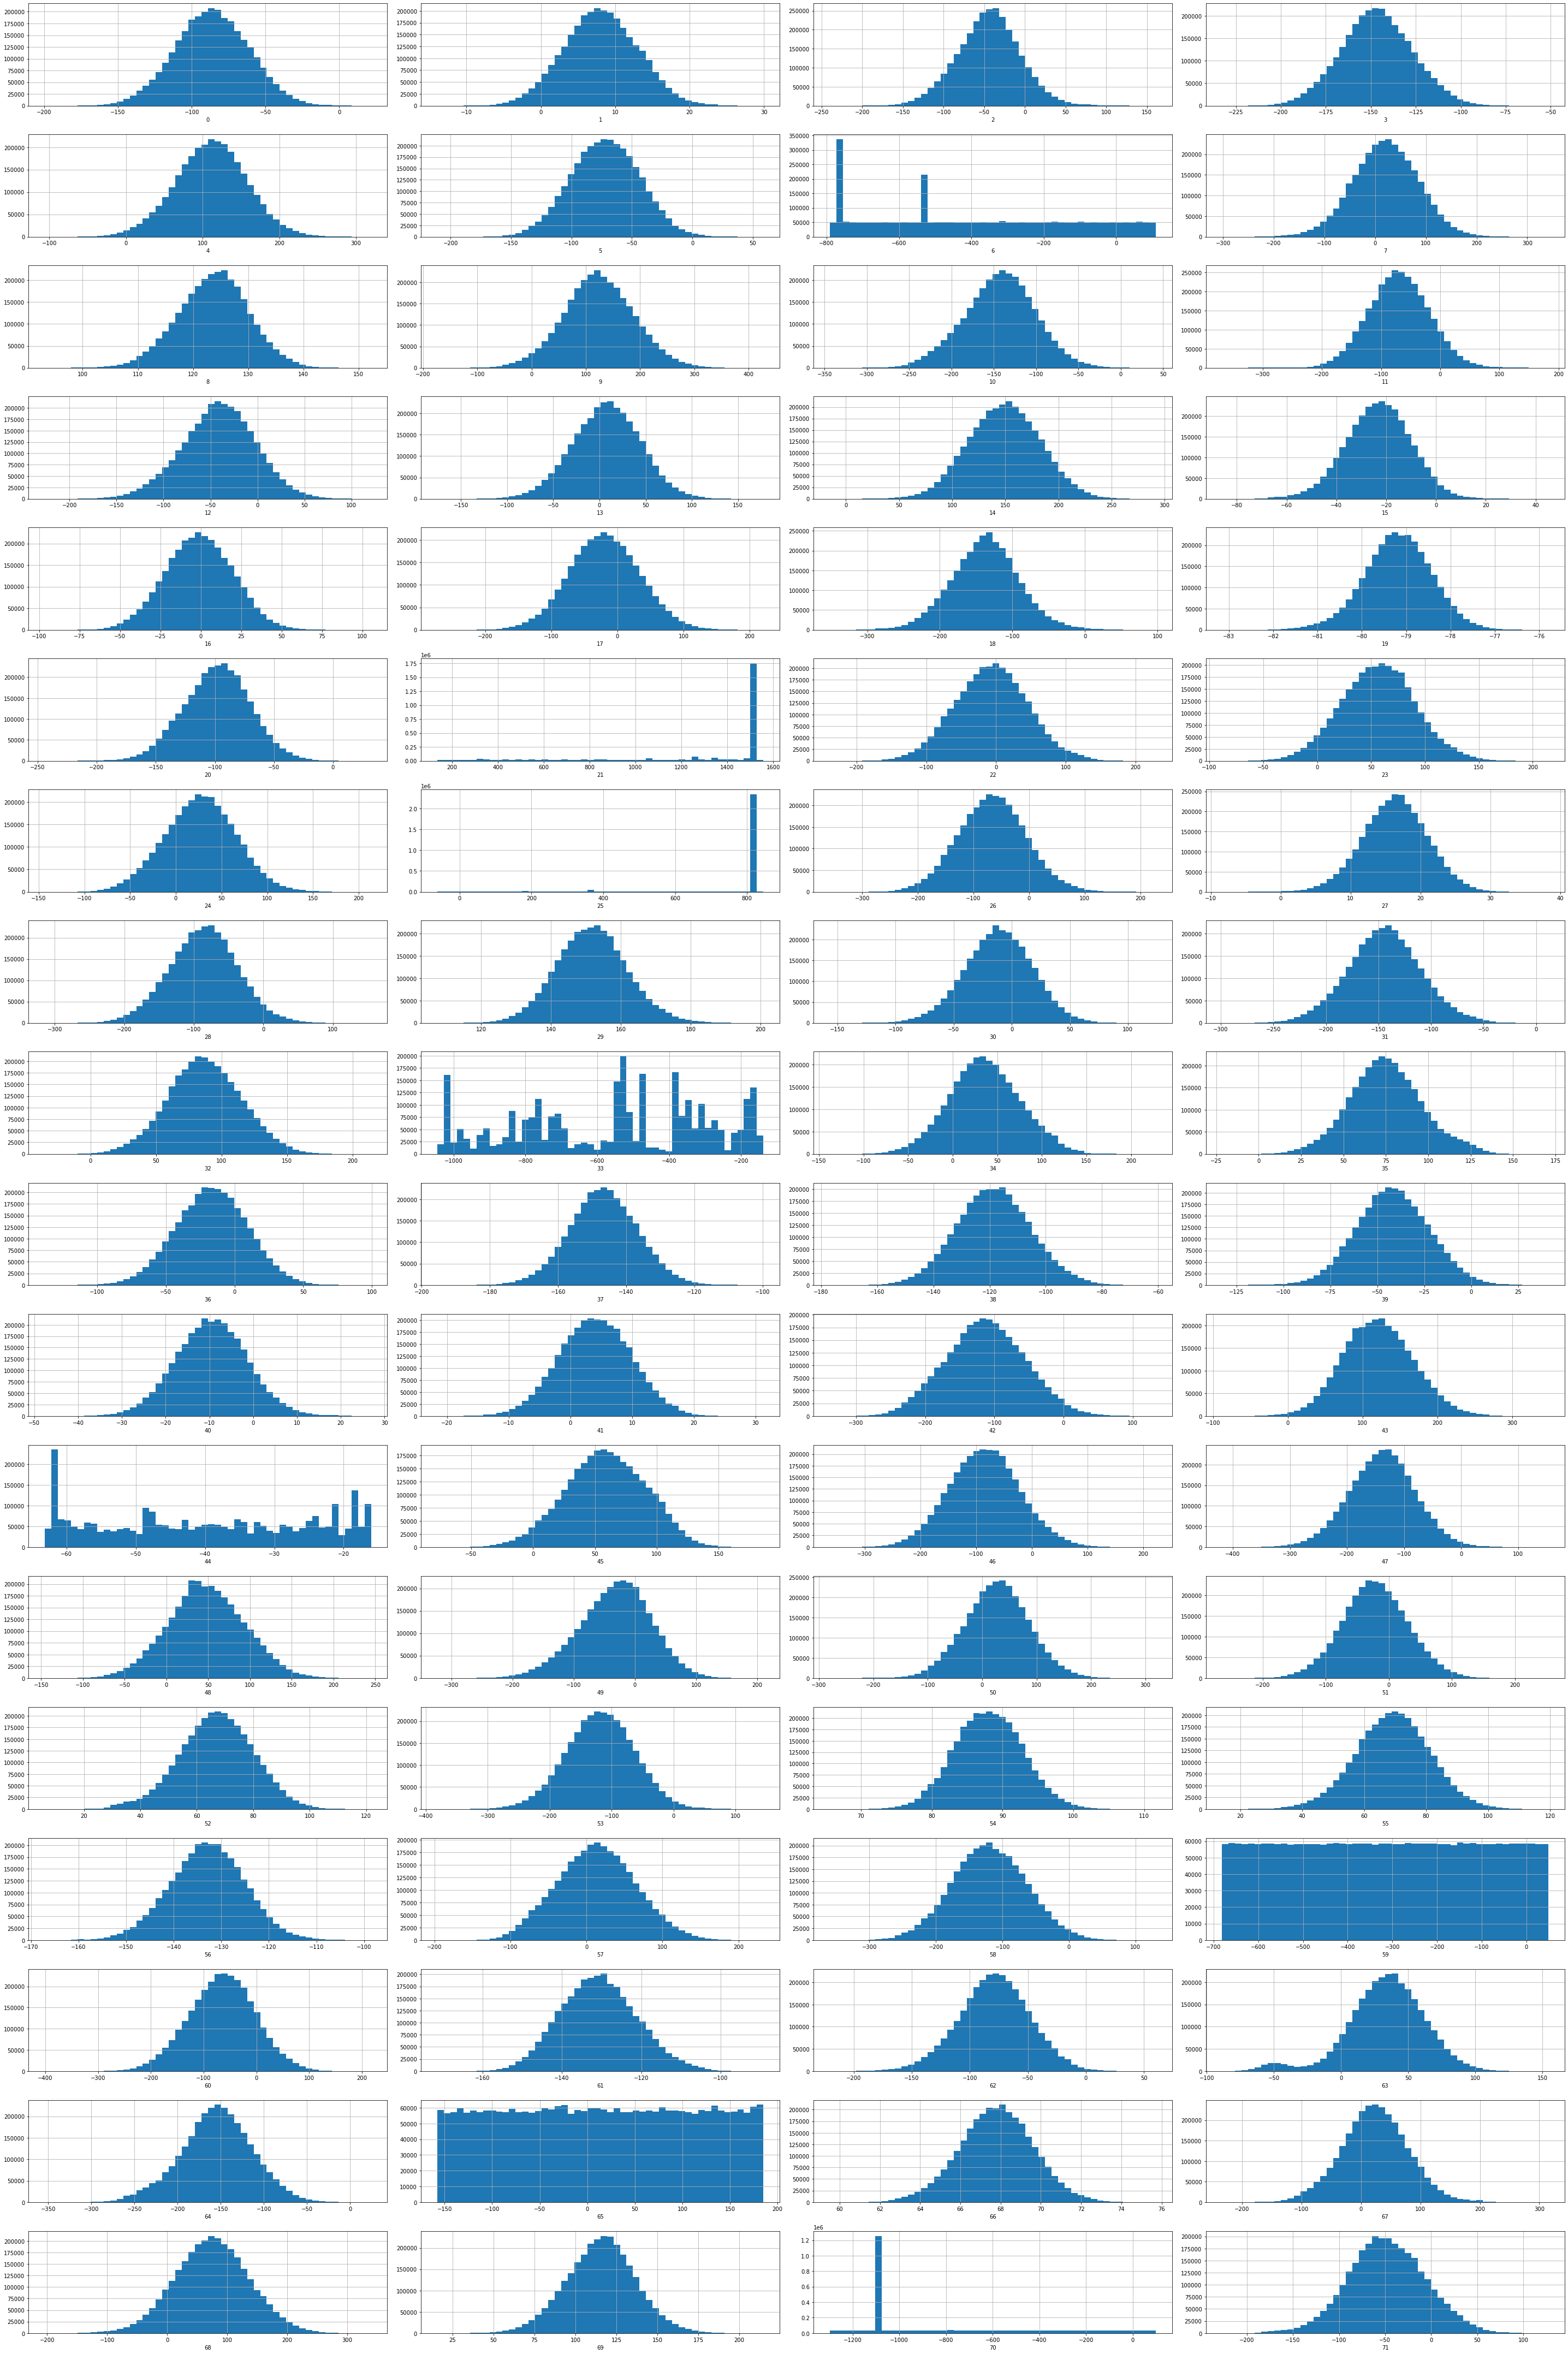

In [11]:
fig = plt.figure(figsize=(40,60))
for i in range(len(df_base.columns)):
    fig.add_subplot(18, 4, i+1)
    plt.hist(df_base[df_base.columns[i]], bins=50)
    plt.xlabel(df_base.columns[i])
    plt.tight_layout()
    plt.grid(True);    

In [12]:
from scipy.stats import jarque_bera
statistic, pvalue = jarque_bera(df_base['71'])
pvalue

0.0

In [13]:
data = np.random.uniform(0, 1, 5000)

In [14]:
from scipy.stats import anderson

result = anderson(data)

print("Statistic: %.3f" % result.statistic)
print("Critical Values:", result.critical_values)
print("Significance Levels:", result.significance_level)

# Check for normality based on the Anderson-Darling test
alpha = 0.05
if result.statistic < result.critical_values[2] and all(level > alpha for level in result.significance_level):
    print("Data looks normally distributed")
else:
    print("Data does not look normally distributed")

Statistic: 59.161
Critical Values: [0.576 0.655 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
Data does not look normally distributed


In [15]:
notnormal_cols = [6, 21, 25,33,44, 59, 65, 70]

Колонки 6,21, 25, 70 имеют неподходящее для обучения распределение.
Колонки 59, 65 не будут влиять на модель.
Колонки 33 и 44 похожи на классовые признаки, так как имеют детерминированный характер поведения графика.


## Предобработка и поиск оптимальных значений

In [77]:
float64_cols = list(df_base.select_dtypes(include='float64'))
# The same code again calling the columns
df = df_base
df[float64_cols] = df_base[float64_cols].astype('float32')

  0%|          | 0/8 [00:00<?, ?it/s]

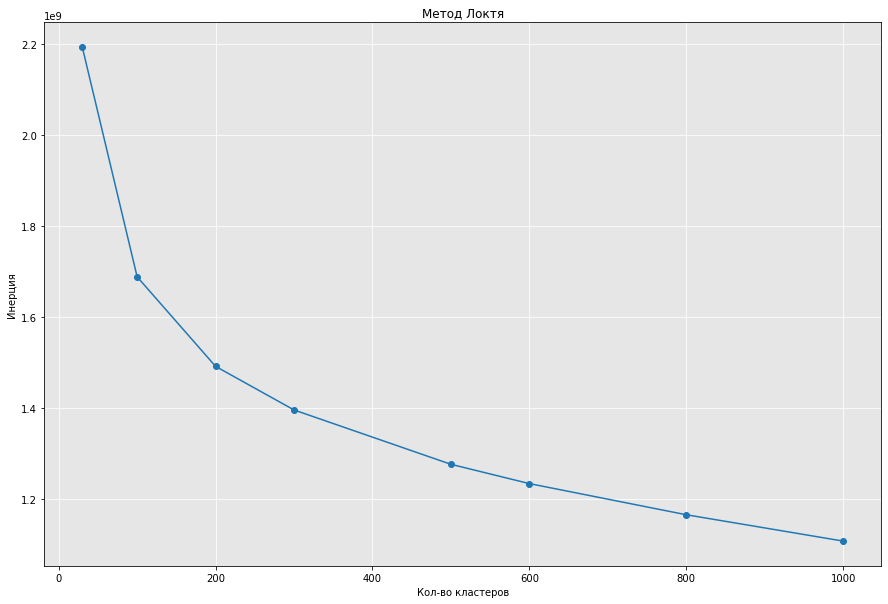

In [89]:
X = df.sample(n=10000, random_state=12345)

inertia = []
list = [1000,800,600,500,300,200,100,30]
for k in tqdm(list):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=12345)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(15,10))
ax = plt.axes(facecolor='#E6E6E6')
ax.set_axisbelow(True)
plt.grid(color='w', linestyle='solid')
plt.plot(list, inertia, marker='o')
plt.title('Метод Локтя')

plt.xlabel('Кол-во кластеров')

plt.ylabel( 'Инерция')

plt.show()

Где-то с 200 начинается плавное снижение инерции, оптимальное значение же лежит около 100-200 кластеров.

In [16]:
overall_scores = {'Кластеры': [],
                  'Поиск в соседних': [],
                  'Опции': [],
                  'accuracy@5': []}
# Функция оценки, а также добавления данных о модели, ее параметрах и сама оценка
def accuracy(targets, idx, base_index, \
                        n_cells, nprobe, comment=''):
    overall_scores['Кластеры'].append(n_cells)
    overall_scores['Поиск в соседних'].append(nprobe)
    overall_scores['Опции'].append(comment)
    score = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        score += int(target in [base_index[r] for r in el])
        result = 100 * score / len(idx)
    overall_scores['accuracy@5'].append(result)
    print(f'Кластеры: {n_cells}, nprobe: {nprobe}, accuracy@5: {result} %')

Создадим бейзлайн и получим метрику качества

In [19]:
dims = df_base.shape[1] #кол-во признаков
n_cells = 1000 #Количество кластеров
k = 5 # Количество ближайших соседей
nprobe=200
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.nprobe = 200 # Поиск в ближайших кластерах
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]))

idx_l2.add(np.ascontiguousarray(df_base.values))
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
r, idx = idx_l2.search(np.ascontiguousarray(df_train).astype('float32'), k)
accuracy(targets, idx, base_index, n_cells, nprobe, 'Baseline')

Кластеры: 1000, nprobe: 200, accuracy@5: 13.803 %


Теперь отмасштабируем данные, чтобы признаки влияли равномерно.

In [20]:
scaler = StandardScaler()
df_base_1 = scaler.fit_transform(df_base)
df_train_1 = scaler.transform(df_train)
# Задаем гиперпараметры для поиска оптимальной модели
n_cells_list = [1000, 500, 200, 100] #кол-во ячеек в индексе
nprobe_list = [2, 10, 15, 20, 30] #кол-во кластеров для поиска

In [21]:
for n_cells in n_cells_list:
    for nprobe in nprobe_list:
        quantizer = faiss.IndexFlatL2(dims)
        idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
        idx_l2.train(np.ascontiguousarray(df_base_1).astype('float32'))
        idx_l2.add(np.ascontiguousarray(df_base_1).astype('float32'))
        idx_l2.nprobe = nprobe
        r, idx = idx_l2.search(np.ascontiguousarray(df_train_1).astype('float32'), k)
        accuracy(targets, idx, base_index, n_cells, nprobe, 'StandardScaler')

Кластеры: 1000, nprobe: 2, accuracy@5: 58.084 %
Кластеры: 1000, nprobe: 10, accuracy@5: 63.738 %
Кластеры: 1000, nprobe: 15, accuracy@5: 64.283 %
Кластеры: 1000, nprobe: 20, accuracy@5: 64.584 %
Кластеры: 1000, nprobe: 30, accuracy@5: 64.933 %
Кластеры: 500, nprobe: 2, accuracy@5: 59.484 %
Кластеры: 500, nprobe: 10, accuracy@5: 64.193 %
Кластеры: 500, nprobe: 15, accuracy@5: 64.599 %
Кластеры: 500, nprobe: 20, accuracy@5: 64.838 %
Кластеры: 500, nprobe: 30, accuracy@5: 65.117 %
Кластеры: 200, nprobe: 2, accuracy@5: 60.097 %
Кластеры: 200, nprobe: 10, accuracy@5: 64.226 %
Кластеры: 200, nprobe: 15, accuracy@5: 64.691 %
Кластеры: 200, nprobe: 20, accuracy@5: 65.002 %
Кластеры: 200, nprobe: 30, accuracy@5: 65.38 %
Кластеры: 100, nprobe: 2, accuracy@5: 60.41 %
Кластеры: 100, nprobe: 10, accuracy@5: 64.602 %
Кластеры: 100, nprobe: 15, accuracy@5: 65.051 %
Кластеры: 100, nprobe: 20, accuracy@5: 65.382 %
Кластеры: 100, nprobe: 30, accuracy@5: 65.657 %


In [22]:
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, 200)
idx_l2.train(np.ascontiguousarray(df_base_1).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_1).astype('float32'))
idx_l2.nprobe = 100
r, idx = idx_l2.search(np.ascontiguousarray(df_train_1).astype('float32'), k)
accuracy(targets, idx, base_index, 200, 100, 'StabdartScaler')

Кластеры: 200, nprobe: 100, accuracy@5: 65.801 %


Протестируем другую модель из библиотеки FAISS

In [23]:
idx = faiss.index_factory(dims,f'IVF{50}_HNSW'+f'{32}'+',Flat')
idx.train(np.ascontiguousarray(df_base_1).astype('float32'))
idx.add(np.ascontiguousarray(df_base_1).astype('float32'))
idx.nprobe = 8
r, idx = idx.search(np.ascontiguousarray(df_train_1).astype('float32'), k)
accuracy(targets, idx, base_index, 50, 8, 'hnsw')

Кластеры: 50, nprobe: 8, accuracy@5: 64.752 %


In [24]:

my_metrics = pd.DataFrame(overall_scores)
my_metrics

,Кластеры,Поиск в соседних,Опции,accuracy@5
0,1000,200,Baseline,13.803
1,1000,2,StandardScaler,58.084
2,1000,10,StandardScaler,63.738
3,1000,15,StandardScaler,64.283
4,1000,20,StandardScaler,64.584
5,1000,30,StandardScaler,64.933
6,500,2,StandardScaler,59.484
7,500,10,StandardScaler,64.193
8,500,15,StandardScaler,64.599
9,500,20,StandardScaler,64.838


Теперь отбросим признаки, распределения которых не являются нормальными и природа их не ясна.

In [25]:
df_base_drop = df_base.drop(df_base.columns[notnormal_cols], axis=1)
df_train_drop = df_train.drop(df_train.columns[notnormal_cols], axis=1)

In [26]:
scaler_1 = StandardScaler()
df_base_drop1 = scaler_1.fit_transform(df_base_drop)
df_train_drop1 = scaler_1.transform(df_train_drop)

In [27]:
dims1 = df_base_drop.shape[1]
quantizer = faiss.IndexFlatL2(dims1)
base_index1 = {k: v for k, v in enumerate(df_base_drop.index.to_list())}
idx_l2 = faiss.IndexIVFFlat(quantizer, dims1, 200)
idx_l2.train(np.ascontiguousarray(df_base_drop1).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_drop1).astype('float32'))
idx_l2.nprobe = 30
r, idx = idx_l2.search(np.ascontiguousarray(df_train_drop1).astype('float32'), 5)
accuracy(targets, idx, base_index1, 200, 30, 'drop_base')

Кластеры: 200, nprobe: 30, accuracy@5: 70.741 %


In [28]:
idx = faiss.index_factory(dims1,f'IVF{100}_HNSW'+f'{32}'+',Flat')
idx.train(np.ascontiguousarray(df_base_drop1).astype('float32'))
idx.add(np.ascontiguousarray(df_base_drop1).astype('float32'))
idx.nprobe = 30
r, idx = idx.search(np.ascontiguousarray(df_train_drop1).astype('float32'), 5)
accuracy(targets, idx, base_index1, 100, 30, 'hnsw_drop')

Кластеры: 100, nprobe: 30, accuracy@5: 70.889 %


Удаленные признаки явно понижали качество нашей модели, дальше будем обходится без них.

Так как выбросы у нас все-таки есть, то попробуем использовать другой метод масштабирования

In [29]:
Robust = RobustScaler()
dims1 = df_base_drop.shape[1]
quantizer = faiss.IndexFlatL2(dims1)
base_index1 = {k: v for k, v in enumerate(df_base_drop.index.to_list())}
df_base_drop2 = Robust.fit_transform(df_base_drop)
df_train_drop2 = Robust.transform(df_train_drop)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims1, 200)
idx_l2.train(np.ascontiguousarray(df_base_drop2).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_drop2).astype('float32'))
idx_l2.nprobe = 30
r, idx = idx_l2.search(np.ascontiguousarray(df_train_drop2).astype('float32'), 5)
accuracy(targets, idx, base_index1, 200, 30, 'Robust+drop')

Кластеры: 200, nprobe: 30, accuracy@5: 70.738 %


In [30]:
idx = faiss.index_factory(dims1,f'IVF{100}_HNSW'+f'{32}'+',Flat')
idx.train(np.ascontiguousarray(df_base_drop2).astype('float32'))
idx.add(np.ascontiguousarray(df_base_drop2).astype('float32'))
idx.nprobe = 30
r, idx = idx.search(np.ascontiguousarray(df_train_drop2).astype('float32'), 5)
accuracy(targets, idx, base_index1, 100, 30, 'hnsw+Robust+drop')

Кластеры: 100, nprobe: 30, accuracy@5: 70.913 %


In [31]:
idx = faiss.index_factory(dims1,f'IVF{50}_HNSW'+f'{32}'+',Flat')
idx.train(np.ascontiguousarray(df_base_drop2).astype('float32'))
idx.add(np.ascontiguousarray(df_base_drop2).astype('float32'))
idx.nprobe = 30
r, idx = idx.search(np.ascontiguousarray(df_train_drop2).astype('float32'), 5)
accuracy(targets, idx, base_index1, 50, 30, 'hnsw+Robust+drop')

Кластеры: 50, nprobe: 30, accuracy@5: 71.038 %


In [46]:
my_metrics = pd.DataFrame(overall_scores)
my_metrics

,Кластеры,Поиск в соседних,Опции,accuracy@5
0,1000,200,Baseline,13.803
1,1000,2,StandardScaler,58.084
2,1000,10,StandardScaler,63.738
3,1000,15,StandardScaler,64.283
4,1000,20,StandardScaler,64.584
5,1000,30,StandardScaler,64.933
6,500,2,StandardScaler,59.484
7,500,10,StandardScaler,64.193
8,500,15,StandardScaler,64.599
9,500,20,StandardScaler,64.838


Поиск закончен, мы нашли оптимальную модель и ее гиперпараметры.

In [65]:
validation_drop = validation.drop(validation.columns[notnormal_cols], axis=1)
validation = Robust.transform(validation_drop)

In [51]:
validation_answer

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base
...,...,...
99995,199995-query,967418-base
99996,199996-query,1344948-base
99997,199997-query,1690782-base
99998,199998-query,341779-base


In [68]:
valid_target = validation_answer['Expected']

In [71]:
idx = faiss.index_factory(dims1,f'IVF{50}_HNSW'+f'{32}'+',Flat')
idx.train(np.ascontiguousarray(df_base_drop2).astype('float32'))
idx.add(np.ascontiguousarray(df_base_drop2).astype('float32'))
idx.nprobe = 30
r, idx = idx.search(np.ascontiguousarray(validation).astype('float32'), 5)
accuracy(valid_target, idx, base_index1, 50, 30, 'hnsw+Robust+drop')

Кластеры: 50, nprobe: 30, accuracy@5: 70.945 %


На валидационной выборке модель показала себя стабильно, оценка почти не изменилась

# Вывод
В результате работы было обнаружено, что предоставленные данные в хорошем качества, за исключением колонок 6, 21, 25,33,44, 59, 65, 70. Возможно, их можно применить для обучения, если узнать их природу и обработать их в соответствии с новой информацией.
Для решения задачи была использована библиотека `FAISS`. В процессе поиска лучшей модели были отобраны лучшие признаки, выбрано оптимальное количество кластеров, были отмасштабированы данные, подобрано количество ближайших для поиска кластеров, выбран тип модели, что дало прирост качества по оценке `@accuracy5` c 13% у бейзлайна до 71%. По итогу лучше всего себя показала модель с такими результатми:

|Модель|Кол-во кластеров|Тип масштабирования|Оценка на трейне|
|-----|-------|------|------|
| FAISS HNSW | 50 | RobustScaler | 71.038 |

На Валидационной выборе результат почти не изменился, и остался в райное 71%. Это подверждает, что модель не была переобучена или, наоборот, не обучена.

Возможные варианты для усовершенствования:
- В поиске ближайших соседей можно использовать другие варианты, к примеру: `IndexFlatIP` или `IndexIVFPQ`
- Можно попробовать другие метрики подчета растояния
- При доступе к большим мощностям можно увеличить точность оптимального количества кластеров
- Выяснить природу столбцов с ненормальным распредлением, чтобы понять, как их можно было бы использовать